In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

import sys

sys.path.append("../src")

from utils.data_loader import load_data

In [17]:
df = load_data("../data/raw/data.csv")

Data loaded successfully from ../data/raw/data.csv


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [11]:

# Set random seed for reproducibility
np.random.seed(42)

In [19]:
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

In [21]:
# 1. Calculate RFM metrics from raw data
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (snapshot_date - x.max()).days,  # Recency
    'TransactionId': 'count',                                         # Frequency
    'Amount': 'sum'                                                   # Monetary
}).rename(columns={
    'TransactionStartTime': 'Recency',
    'TransactionId': 'Frequency',
    'Amount': 'Monetary'
}).reset_index()

In [22]:
print("RFM Metrics Summary:")
print(rfm.describe())

RFM Metrics Summary:
           Recency    Frequency      Monetary
count  3742.000000  3742.000000  3.742000e+03
mean     31.461251    25.564404  1.717377e+05
std      27.118932    96.929602  2.717305e+06
min       1.000000     1.000000 -1.049000e+08
25%       6.000000     2.000000  4.077438e+03
50%      25.000000     7.000000  2.000000e+04
75%      54.000000    20.000000  7.996775e+04
max      91.000000  4091.000000  8.345124e+07


In [23]:
## Step 2: Pre-process RFM features for clustering

# Check for and handle zeros/negatives (log transform can't handle zeros/negs)
rfm['Frequency'] = rfm['Frequency'].apply(lambda x: 1 if x <=0 else x)
rfm['Monetary'] = rfm['Monetary'].apply(lambda x: 0.01 if x <=0 else x)

# Apply log transformation to handle skewness
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1).values

# Standardize the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)



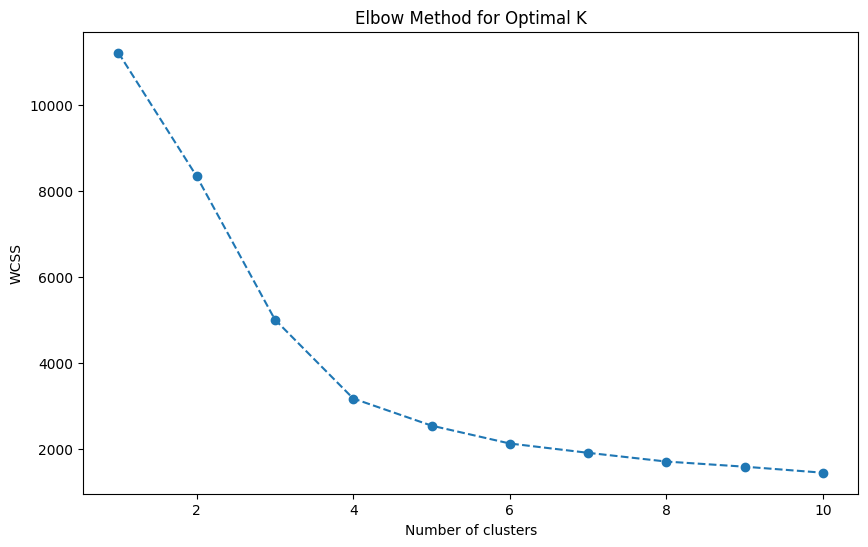

In [24]:

## Step 3: Perform K-Means clustering

# Determine optimal number of clusters using Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow plot, we'll choose 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Add cluster labels to the RFM dataframe
rfm['Cluster'] = clusters



Cluster Summary:
           Recency  Frequency       Monetary  Count
Cluster                                            
0        38.131250  11.590341  120606.111443   1760
1         4.759036  73.651606  545776.753394    996
2        46.528398   1.933063    2574.098347    986


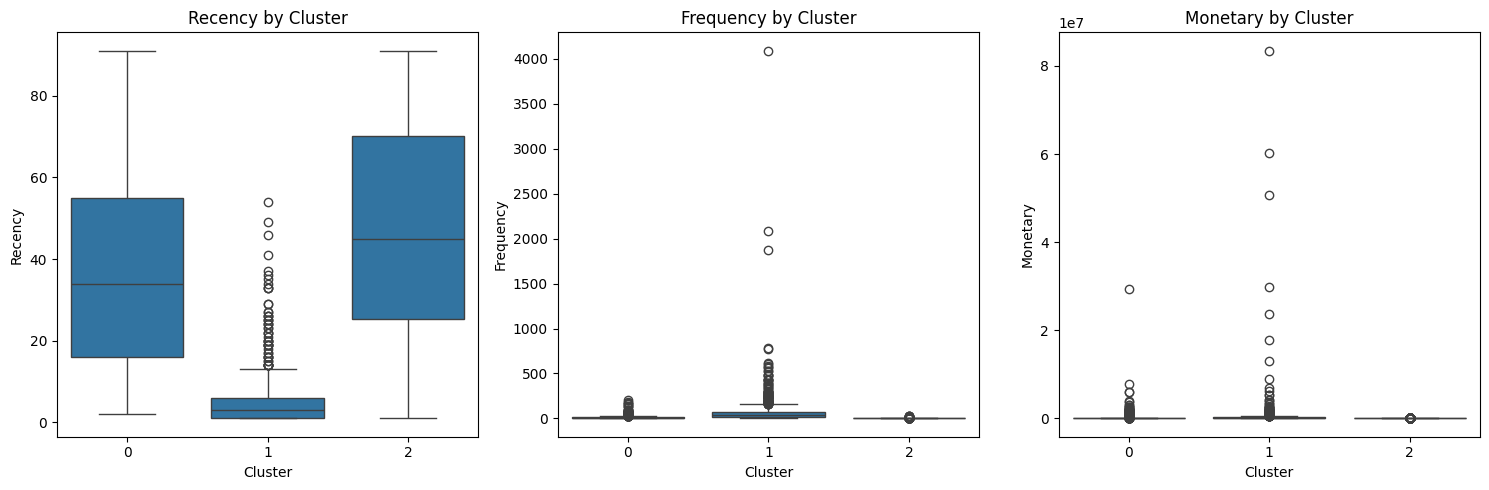

In [25]:

## Step 4: Analyze clusters and identify high-risk group

# Calculate average RFM values per cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerId': 'count'
}).rename(columns={'CustomerId': 'Count'})

print("\nCluster Summary:")
print(cluster_summary)

# Visualize clusters
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recency by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.show()


In [ ]:
# Based on the analysis, identify which cluster is high-risk
# Typically the cluster with high Recency (not transacted recently), 
# low Frequency and low Monetary value
high_risk_cluster = cluster_summary.sort_values(
    by=['Recency', 'Frequency', 'Monetary'], 
    ascending=[False, True, True]
).index[0]

print(f"\nIdentified high-risk cluster: {high_risk_cluster}")

## Step 5: Create and integrate the target variable

# Create binary target variable
rfm['is_high_risk'] = (rfm['Cluster'] == high_risk_cluster).astype(int)

# Merge the target variable back to the main dataset
df = df.merge(rfm[['CustomerId', 'is_high_risk']], on='CustomerId', how='left')

# Check the distribution of the target variable
print("\nTarget Variable Distribution:")
print(df['is_high_risk'].value_counts(normalize=True))




Identified high-risk cluster: 2

Target Variable Distribution:
is_high_risk
0    0.980076
1    0.019924
Name: proportion, dtype: float64

Task 4 completed successfully. Target variable 'is_high_risk' added to dataset.


In [27]:
# Save the updated dataset
df.to_csv('../data/processed/data_with_target.csv', index=False)

print("\nTask 4 completed successfully. Target variable 'is_high_risk' added to dataset.")


Task 4 completed successfully. Target variable 'is_high_risk' added to dataset.
